# Generalized Lotka Volterra: joint alternate estimation for inverse problem

*Hugo Gangloff$^1$, Nicolas Jouvin$^1$, Lorenzo Sala$^2$ - December 2025*

$^1$ Université Paris-Saclay, AgroParisTech, INRAE UMR MIA Paris-Saclay, France

$^2$ Université Paris-Saclay, INRAE, MaIAGE, 78350, Jouy-en-Josas, France 

**Abstract: In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. We will also **make use of available observations** and we will also **differentiate the dynamic loss with respect to the equation parameter $\theta$**.

**Outline**

1. [Mathematical background](#Mathematical-background)
2. [Code set-up](#Code-set-up)
3. [Joint alternate training (simple)](#Joint-alternate-training-(simple))
4. [Joint alternate training (regularized)](#Joint-alternate-training-(regularized))
5. [Vanilla joint training](#Vanilla-joint-training)
6. [Vanilla joint training (regularized)](#Vanilla-joint-training-(regularized))
7. [Comparison of the approaches](#Comparison-of-the-approaches)

## Mathematical background

On the time interval $I=[0, T]$, we consider a **Generalized Lotka Volterra** system with $N_s$ populations, $\forall t\in I$, where $x_i(t)$ denotes the abundance (biomass) of species $i$ at time $t$:

$$
\frac{dx_i(t)}{dt} = \mu_i x_i(t) + \sum_{j=1}^{N_s} a_{ij} x_i(t) x_j(t), 
\quad i = 1, \dots, N_s,
$$

where $\mu_i$ are the growth rates and $a_{ij}$ are the interactions terms. We also have some initial conditions $x_i(0) = x_{i,0} > 0$.

We will work with the GLV equation in logarithmic (for stability and positiveness) and vectorial form (for concision):

$$
\frac{du(t)}{dt} = \mu + A \exp(u(t)),
$$
where $u(t) = (\log x_1(t), \dots, \log x_{N_s}(t))^\top$, 
$\mu = (\mu_1, \dots, \mu_{N_s})^\top$, 
and $A = (a_{ij})_{1 \le i,j \le N_s}$. Therefore $\theta=\{\mu, A\}$.

We are working the context of **inverse problem**, we also have at our disposal **noisy observations of the solution** at some sampled times $\{t_j, u_j\}_{j=1}^{n_o}$ that we will use to estimate both the solution $u$ and the parameters $\theta$. We work the in the **PINN methodology**, we approximate the solution as a neural network $u_\nu : I \mapsto \mathbb{R}^{N_s}$, where $\nu$ are the weights and biases of the neural network that we need to estimate.


Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_\nu(t_i)}{dt} - \mu - A \exp(u_\nu(t_i))\Vert^2 + \Vert u_\nu(0) - u_0 \Vert_2^2\\
&+\frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2,
\end{align*}
$$

where $\{t_i\}_{i=1}^{i=n_c}$ is a set of randomly selected collocation points and $u_0=(\log x_{1, 0}, \dots, \log x_{N_s,0})$ is the vector of initial condition values.

More precisely, [Sections 3](#Joint-alternate-training-(simple)) and [Section 4](#Joint-alternate-training-(regularized)) will consider a slightly modified version of the problem above, namely, an alternate optimization between $\nu$ and $\theta=\{\mu,A\}$ will be set up.

- The optimization scheme for step $n+1$ can then be written for [Section 3](#Joint-alternate-training-(simple)):

$$
\begin{align*}
        \{\mu,A\}^{[n+1]} & \leftarrow \arg\min_{\{\mu,A\}} \frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_{\nu^{[n]}}(t_i)}{dt} - \mu - A \exp(u_{\nu^{[n]}}(t_i))\Vert^2 \\
        \nu^{[n+1]} & \leftarrow \arg\min_{\nu} \mathcal{L}(\nu,\{\mu,A\}^{[n+1]}).
\end{align*}
$$

- The optimization scheme for step $n+1$ can then be written for [Section 4](#Joint-alternate-training-(regularized)):

$$
\begin{align*}
        \{\mu,A\}^{[n+1]} & \leftarrow \arg\min_{\{\mu,A\}} \frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_{\nu^{[n]}}(t_i)}{dt} - \mu - A \exp(u_{\nu^{[n]}}(t_i))\Vert^2 + \lambda_\theta \Vert \theta \Vert_1  \\
        \nu^{[n+1]} & \leftarrow \arg\min_{\nu} \mathcal{L}(\nu,\{\mu,A\}^{[n+1]}) + \lambda_\nu \Vert\nu\Vert^2_2,
\end{align*}
$$

where we added a lasso penalization on the coefficients $\theta$ and a ridge regularization on $\nu$.

On the other hand, [Section 5](#Vanilla-joint-training) and [Section 6](#Vanilla-joint-training-(regularized)) will perform a direct joint optimization on both set of parameters.

- The optimization problem can then be written for [Section 5](#Vanilla-joint-training):

$$
\hat{\nu},\hat{\theta} = \arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta).
$$

- The optimization problem can then be written for [Section 6](#Vanilla-joint-training-(regularized)):

$$
\hat{\nu},\hat{\theta} = \arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta) + \lambda_\nu \Vert\nu\Vert^2_2  + \lambda_\theta \Vert \theta \Vert_1.
$$

**Initialization**: in all cases:

- $\theta$ is initialization to the $0$ of its vector space.

- $\nu$ parameters are first initialized with `equinox` default initialization for weight and biaises in linear layers. However a **pretraining on data only** is performed for all optimization problems. That is the joint optimizations all begin with a $\nu^{ini}$ such that:

$$
\nu^{ini} = \arg\min_{\nu} \frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2
$$

## Code set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax

# from jax import config
# config.update("jax_enable_x64", True)
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

In [4]:
key = jax.random.PRNGKey(0)

W1210 15:53:29.611466   41428 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1210 15:53:29.614863   41321 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Define the equation parameters

Time domain

In [5]:
tmin = 0
tmax = 1

Tmax = 200

In [6]:
# initial conditions for each species

### 3 population example
# Ns = 3
# N_0 = onp.array([3.0, 1.0, 4.0])
# # growth rates for each species
# growth_rates = jnp.array([0.01, 0.05, 0.04])

# # interactions
# interactions = -jnp.array([[0, 0.2, 0.1], [0.1, 0, 0.1], [0.1, 0.2, 0]])

### 10 population example
key, subkey = jax.random.split(key)

Ns = 10
A = jax.random.normal(subkey, shape=(Ns, Ns)) * 1e-2
key, subkey = jax.random.split(key)
dA = jnp.diag(A)
key, subkey = jax.random.split(key)
A *= jax.random.bernoulli(subkey, p=0.4, shape=A.shape)
A = A - A.T
A = A + jnp.diag(-jnp.abs(dA))
interactions = A
key, subkey = jax.random.split(key)
growth_rates = jnp.abs(jax.random.normal(subkey, shape=(Ns,))) * 1e-1
key, subkey = jax.random.split(key)
N_0 = jax.random.uniform(subkey, shape=(Ns,)) * 10

In [7]:
key, subkey = jax.random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=500,
    tmin=tmin,
    tmax=tmax,
    method="uniform",
    temporal_batch_size=None,
)

ts = val_data.times.sort(axis=0).squeeze()
# NOTE parfois np.any(np.diff(ts) <= 0) qui provoque une erreur dans solve_ivp
# mais on a toujours np.any(np.diff(ts) < 0)

### Observations

We use observations obtained from a run of a ground truth solver/

In [8]:
import numpy as np
from scipy.integrate import solve_ivp


def GLV_RHS(t, y, theta):
    """
    This equation is given in log space. That means the input y is the logarithm of the population density
    """
    alpha, gamma = theta
    return (alpha + (gamma @ jnp.exp(y).reshape((gamma.shape[0], 1))).squeeze()).ravel()


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
eq_params = (growth_rates, interactions)

# Define initial bacterial populations
y0 = N_0

# Define time points
t = ts * Tmax

############################

y0_log = np.log(y0)
sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(eq_params,),
)
y = np.exp(sol_log.y).T

In [9]:
val_data.times.shape

(500, 1)

In [10]:
np.any(np.diff(ts) <= 0)

np.False_

In [11]:
n = 500
subsample_size = 10
subsample = jnp.arange(n)
subsample = subsample[:: int(n / (subsample_size - 1))]
subsample = jnp.append(subsample[:-1], n - 1)

# key, subkey = jax.random.split(key)
# subsample = jnp.sort(
#    jax.random.choice(subkey, n - 3, shape=(subsample_size - 2,), replace=False) + 1
# ).astype(jnp.int16)
# subsample = jnp.append(jnp.array([0]), subsample)
# subsample = jnp.append(subsample, n - 1)

t_subsample = ts[subsample]
log_obs_subsample = jnp.log(y[subsample])

__Optionally blur the observed values__

In [12]:
noise_level = 0.2

key, subkey = jax.random.split(key)
noise = noise_level * jax.random.normal(subkey, shape=log_obs_subsample.shape)
log_obs_subsample_noisy = log_obs_subsample + noise
# obs_subsample_noisy = jnp.where(obs_subsample_noisy < 1e-6, 1e-6, obs_subsample_noisy)

**Visualize the noisy observations**

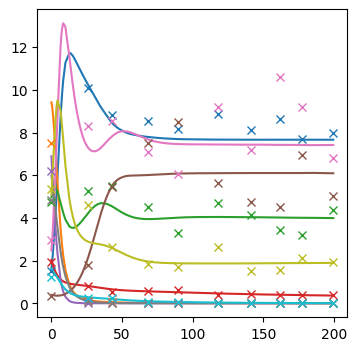

In [13]:
plt.plot(ts * Tmax, y)
plt.gca().set_prop_cycle(None)
plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.show()

### Estimate the solution and the parameters of the GLV system

*Define the domain and the associated data generator*

In [14]:
key, subkey = jax.random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=5000,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=None,
    method="uniform",
)

*Define the data generator for the observations*

In [15]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=None,
    observed_pinn_in=t_subsample,
    observed_values=log_obs_subsample_noisy,
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [16]:
N_neurons = 7 * Ns
eqx_list = (
    (eqx.nn.Linear, 1, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, Ns),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

*Define the jinns parameter object. **Equation parameters are initialized to 0 everywhere.***

In [17]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "g": jnp.zeros_like(growth_rates),
        "i": jnp.zeros_like(interactions),
    },
)

*Define the loss weights*

In [18]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1.0 / Tmax, initial_condition=1.0, observations=1.0
)

*Define the dynamic loss term*

In [19]:
class GLV_loss(jinns.loss.ODE):
    def equation(self, t, u, params):
        """
        This equation is given in log, this means that u is the log of the population density
        """
        udt = jax.jacfwd(lambda x: u(x, params))(t).squeeze()
        f = udt - self.Tmax * GLV_RHS(
            t, u(t, params), (params.eq_params.g, params.eq_params.i)
        )
        return f


dynamic_loss = GLV_loss(Tmax=Tmax)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [20]:
derivative_keys = jinns.parameters.DerivativeKeysODE.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "g": jax.tree.map(lambda _: True, init_params.eq_params.g),
            "i": jax.tree.map(lambda _: True, init_params.eq_params.i),
        },
    ),
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the ODE PINN losses*

In [21]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

*We will start with a PINN pretraining on observations only. One argument in favor of such pretraining is  to avoid $\theta$ collapsing to $0$. All approaches that will follow will benefit from this pretraining.*

**Pretraining**

In [22]:
pretrain_loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=0.0,
    initial_condition=1.0,
    observations=1.0,  # ZERO to block gradients from dynamic loss
)
pretrain_loss = jinns.loss.LossODE(
    u=u,
    loss_weights=pretrain_loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [23]:
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN pretraining with observations only")
(
    pretrain_params,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    stored_loss_weight_terms,
    _,
    _,
    _,
    _,
) = jinns.solve(
    n_iter=10000,
    init_params=init_params,
    data=train_data,
    optimizer=pretrain_tx,
    loss=pretrain_loss,
    obs_data=obs_data,
    print_loss_every=1000,
    key=subkey,
)

PINN pretraining with observations only
Initialization time: 0.5446162223815918

Compilation took
 5.896533489227295 

[train] Iteration 0: loss value = 1053.4600830078125
[train] Iteration 1000: loss value = 758.7393798828125
[train] Iteration 2000: loss value = 260.50933837890625
[train] Iteration 3000: loss value = 92.99662017822266
[train] Iteration 4000: loss value = 34.39625930786133
[train] Iteration 5000: loss value = 11.921135902404785
[train] Iteration 6000: loss value = 4.0797953605651855
[train] Iteration 7000: loss value = 1.2715222835540771
[train] Iteration 8000: loss value = 0.30471962690353394
[train] Iteration 9000: loss value = 0.12423726916313171

Stopping main optimization loop, cause: max iteration is reached

Training took
 44.465590715408325 


Final iteration 10000: train loss value = 0.10573229938745499


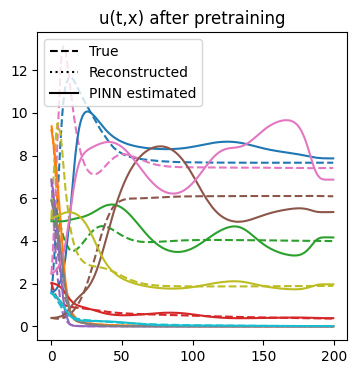

In [24]:
from matplotlib.lines import Line2D

pretrain_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, pretrain_params)))

plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, pretrain_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after pretraining")
legend_elements = [
    Line2D([0], [0], color="k", linestyle="--", label="True"),
    Line2D([0], [0], color="k", linestyle="dotted", label="Reconstructed"),
    Line2D([0], [0], color="k", label="PINN estimated"),
]
# Create the figure
plt.legend(handles=legend_elements, loc="upper left")
plt.show()

In [25]:
assert jnp.allclose(
    total_loss_values,
    loss_by_term_dict.observations * pretrain_loss_weights.observations
    + loss_by_term_dict.initial_condition * pretrain_loss_weights.initial_condition,
)  # check that we only use observations and initial conditions

**The next cell defines the number of iterations and is common to all the methods, with a slight adaptation for the non alternate methods**

In [26]:
# number of alternate iterations
n_iter = 300
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=250,
    eq_params={"g": 250, "i": 250},
)

### Joint alternate training (simple)

**with `jinns.solve_alternate()`**

*We will need to construct the object needed for the `jinns.solve_alternate()` call.*

**Alternate joint estimation**

In [27]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

In [28]:
start_learning_rate = 1e-3


# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=start_learning_rate),
    eq_params={
        "g": optax.chain(
            optax.adam(learning_rate=start_learning_rate),
            update_and_project_g(),
        ),
        "i": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },
)

*We now start the alternate training*

In [29]:
(
    params_alternate,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 8.727796077728271
[train alternate]Iteration 0: loss value = 14.34946060180664
[train alternate]Iteration 20: loss value = 1.7953460216522217
[train alternate]Iteration 40: loss value = 0.32997041940689087
[train alternate]Iteration 60: loss value = 0.17525522410869598
[train alternate]Iteration 80: loss value = 0.14413225650787354
[train alternate]Iteration 100: loss value = 0.1333557367324829
[train alternate]Iteration 120: loss value = 0.11240368336439133
[train alternate]Iteration 140: loss value = 0.1048470214009285
[train alternate]Iteration 160: loss value = 0.08992545306682587
[train alternate]Iteration 180: loss value = 0.08230972290039062
[train alternate]Iteration 200: loss value = 0.08312037587165833
[train alternate]Iteration 220: loss value = 0.07413015514612198
[train alternate]Iteration 240: loss value = 0.07186654955148697
[train alternate]Iteration 260: loss value = 0.07155513018369675
[train alternate]Iteration 280: loss value = 0.067148886620998

**Results**

*Plot the loss values*

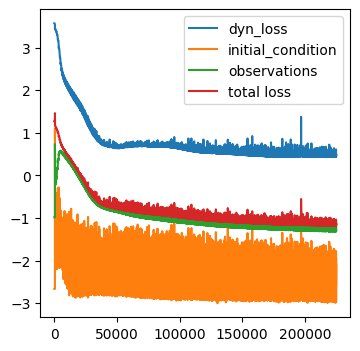

In [30]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Joint alternate training (regularized)

**with `jinns.solve_alternate()`**

In [31]:
from utils_GLV_JointEstimation_Alternate import soft_thresholding_additive_update

soft_thresholding_additive_update_g = partial(
    soft_thresholding_additive_update, param="g"
)
soft_thresholding_additive_update_i = partial(
    soft_thresholding_additive_update, param="i"
)

In [32]:
# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=1e-3),
    eq_params={
        "g": optax.chain(
            optax.sgd(learning_rate=1e-3),
            soft_thresholding_additive_update_g(learning_rate=1e-3, l1reg=None),
        ),
        "i": optax.chain(
            optax.sgd(learning_rate=1e-6),
            soft_thresholding_additive_update_i(learning_rate=1e-6, l1reg=1e-3),
        ),
    },
)

In [33]:
(
    params_alternate_regularized,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=init_params,  # pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 5.752143383026123
[train alternate]Iteration 0: loss value = 862.316650390625
[train alternate]Iteration 20: loss value = 9.642353057861328
[train alternate]Iteration 40: loss value = 0.2850460708141327
[train alternate]Iteration 60: loss value = 0.19310002028942108
[train alternate]Iteration 80: loss value = 0.1661977469921112
[train alternate]Iteration 100: loss value = 0.14171384274959564
[train alternate]Iteration 120: loss value = 0.13978198170661926
[train alternate]Iteration 140: loss value = 0.12332894653081894
[train alternate]Iteration 160: loss value = 0.12055501341819763
[train alternate]Iteration 180: loss value = 0.11342041939496994
[train alternate]Iteration 200: loss value = 0.11246786266565323
[train alternate]Iteration 220: loss value = 0.10551483929157257
[train alternate]Iteration 240: loss value = 0.10290895402431488
[train alternate]Iteration 260: loss value = 0.10690246522426605
[train alternate]Iteration 280: loss value = 0.10133733600378036

**Results**

*Plot loss values*

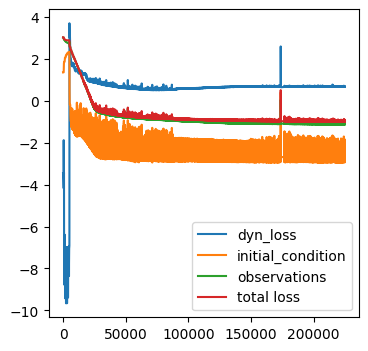

In [34]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Vanilla joint training

**with `jinns.solve()`**

**Loss for `jinns.solve()`**

In [35]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=jinns.loss.LossWeightsODE(
        dyn_loss=1.0,
        initial_condition=1.0,
        observations=1.0,
    ),
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [36]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_adam",
        "i": "i_adam",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.adamw(learning_rate=1e-3),
        "g_adam": optax.chain(
            optax.adam(learning_rate=1e-3),
            update_and_project_g(),
        ),
        "i_adam": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [37]:
params_vanilla, total_loss_values, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=pretrain_params,
        data=train_data,
        optimizer=tx_nu_and_theta,
        loss=loss,
        n_iter=n_iter_nu_and_theta,
        obs_data=obs_data,
        print_loss_every=10000,
    )
)

Initialization time: 0.22090983390808105

Compilation took
 2.9352264404296875 

[train] Iteration 0: loss value = 3721.631591796875
[train] Iteration 10000: loss value = 7.838674545288086
[train] Iteration 20000: loss value = 1.3720595836639404
[train] Iteration 30000: loss value = 0.6156606674194336
[train] Iteration 40000: loss value = 0.39295345544815063
[train] Iteration 50000: loss value = 0.5318679213523865
[train] Iteration 60000: loss value = 0.29547667503356934
[train] Iteration 70000: loss value = 0.28172019124031067

Stopping main optimization loop, cause: max iteration is reached

Training took
 340.35668182373047 


Final iteration 75000: train loss value = 0.28806376457214355


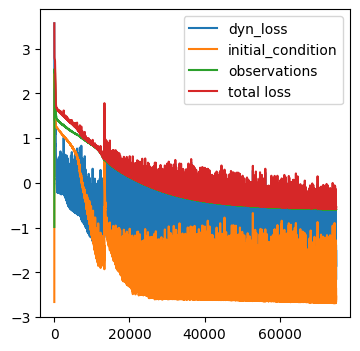

In [38]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Vanilla joint training (regularized)

**with `jinns.solve()`**

Here we must decrease a lot learning rates for `eq_params` otherwise we get exploding gradients.

In [78]:
from functools import partial
from utils_GLV_JointEstimation_Alternate import update_and_project

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_prox",
        "i": "i_prox",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.adamw(learning_rate=1e-3),
        "g_prox": optax.chain(
            optax.sgd(learning_rate=1e-5),
            soft_thresholding_additive_update_g(learning_rate=1e-5, l1reg=None),
        ),
        "i_prox": optax.chain(
            optax.sgd(learning_rate=1e-8),
            soft_thresholding_additive_update_i(learning_rate=1e-8, l1reg=1e-8),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [79]:
(
    params_vanilla_regularized,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
) = jinns.solve(
    init_params=pretrain_params,
    data=train_data,
    optimizer=tx_nu_and_theta,
    loss=loss,
    n_iter=n_iter_nu_and_theta,
    obs_data=obs_data,
    print_loss_every=10000,
)

Initialization time: 0.19492197036743164

Compilation took
 2.7978250980377197 

[train] Iteration 0: loss value = 3721.631591796875
[train] Iteration 10000: loss value = 1.3834608793258667
[train] Iteration 20000: loss value = 0.8053991198539734
[train] Iteration 30000: loss value = 0.4594483971595764
[train] Iteration 40000: loss value = 0.607419490814209
[train] Iteration 50000: loss value = 0.45383793115615845
[train] Iteration 60000: loss value = 0.39016810059547424
[train] Iteration 70000: loss value = 0.45914483070373535

Stopping main optimization loop, cause: max iteration is reached

Training took
 340.5249123573303 


Final iteration 75000: train loss value = 0.3644067347049713


*Errors on parameters*

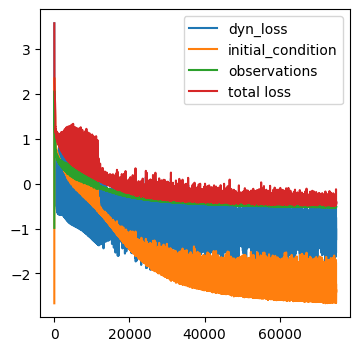

In [80]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

## Comparison of the approaches

*Error on parameters*

In [81]:
from dataclasses import fields


def errors_on_parameters(true, estimated):
    return_dict = {}
    for f in fields(estimated.eq_params):
        p = getattr(estimated.eq_params, f.name)
        p_true = getattr(true, f.name)

        rmse = jnp.mean(
            jax.tree.reduce(  # the tree.reduce does not have an effect on carrying_capacities and growth_rates
                lambda a, b: (a + b) / 2,
                jax.tree.map(lambda p1, p2: (p1 - p2) ** 2, p, p_true),
                0,
            )
        )
        return_dict[f.name] = rmse.item()
    return return_dict

In [82]:
from jinns.parameters import EqParams

true_params = EqParams({"g": growth_rates, "i": interactions})

rmse_parameters_alternate = errors_on_parameters(true_params, params_alternate)
rmse_parameters_alternate_regularized = errors_on_parameters(
    true_params, params_alternate_regularized
)
rmse_parameters_vanilla = errors_on_parameters(true_params, params_vanilla)
rmse_parameters_vanilla_regularized = errors_on_parameters(
    true_params, params_vanilla_regularized
)

In [84]:
print(f"{rmse_parameters_alternate=}")
print(f"{rmse_parameters_alternate_regularized=}")
print(f"{rmse_parameters_vanilla=}")
print(f"{rmse_parameters_vanilla_regularized=}")

rmse_parameters_alternate={'g': 0.0053801643662154675, 'i': 0.00014366836694534868}
rmse_parameters_alternate_regularized={'g': 0.004308836068958044, 'i': 4.907239417661913e-05}
rmse_parameters_vanilla={'g': 0.0029364419169723988, 'i': 3.1194107577903196e-05}
rmse_parameters_vanilla_regularized={'g': 0.002965118270367384, 'i': 2.922394014603924e-05}


*Errors on the curves*

In [85]:
def error_on_the_curves(y, pinn_estimated_function, params_estimated):
    """
    y: true curves
    """
    # Profiled error: RMSE error between the true curve and the PINN estimation
    rmse_p = jnp.sum(
        jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(
            y, pinn_estimated_function(ts)
        )
    )
    # print("RMSE profiled error", rmse_p)

    # Reconstructed error: RMSE error between the true curve and the ground truth solver solution run
    # with the system parameters estimated by jinns.solve_alternate()
    rec_sol_log = solve_ivp(
        fun=GLV_RHS,
        y0=y0_log,
        t_span=(0, Tmax),
        t_eval=ts * Tmax,
        args=(
            (
                params_estimated.eq_params.g,
                params_estimated.eq_params.i,
            ),
        ),
    )
    rec_y = np.exp(rec_sol_log.y).T
    rmse_r = jnp.sum(jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, rec_y))
    # print("RMSE profiled error", rmse_r)

    rmse_curves = {"profiled": rmse_p.item(), "reconstructed": rmse_r.item()}
    return rmse_curves, rec_sol_log

In [86]:
trained_u_est_alternate = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_alternate)))
trained_u_est_alternate_regularized = jax.vmap(
    lambda t_x: jnp.exp(u(t_x, params_alternate_regularized))
)
trained_u_est_vanilla = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_vanilla)))
trained_u_est_vanilla_regularized = jax.vmap(
    lambda t_x: jnp.exp(u(t_x, params_vanilla_regularized))
)


rmse_curves_alternate, rec_sol_log_alternate = error_on_the_curves(
    y, trained_u_est_alternate, params_alternate
)
rmse_curves_alternate_regularized, rec_sol_log_alternate_regularized = (
    error_on_the_curves(
        y, trained_u_est_alternate_regularized, params_alternate_regularized
    )
)
rmse_curves_vanilla, rec_sol_log_vanilla = error_on_the_curves(
    y, trained_u_est_vanilla, params_vanilla
)
rmse_curves_vanilla_regularized, rec_sol_log_vanilla_regularized = error_on_the_curves(
    y, trained_u_est_vanilla_regularized, params_vanilla_regularized
)

In [87]:
print(f"{rmse_curves_alternate=}")
print(f"{rmse_curves_alternate_regularized=}")
print(f"{rmse_curves_vanilla=}")
print(f"{rmse_curves_vanilla_regularized=}")

rmse_curves_alternate={'profiled': 6.927318572998047, 'reconstructed': 5.416436672210693}
rmse_curves_alternate_regularized={'profiled': 6.454630374908447, 'reconstructed': 5.723559379577637}
rmse_curves_vanilla={'profiled': 11.313011169433594, 'reconstructed': 11.416744232177734}
rmse_curves_vanilla_regularized={'profiled': 9.3118314743042, 'reconstructed': 9.49795913696289}


In [88]:
from matplotlib.lines import Line2D


def plot_curves(title, rec_sol_log, pinn_estimated_function):
    plt.plot(ts * Tmax, y)
    plt.gca().set_prop_cycle(None)
    if rec_sol_log.status == 0:
        rec_y = np.exp(rec_sol_log.y).T
        plt.plot(ts * Tmax, rec_y, linestyle="dotted", label="Reconstructed")
    else:
        print(
            "Warning! Curves from scipy solver with estimated parameters are not plotted because a problem appeared in the resolution"
        )
    plt.gca().set_prop_cycle(None)
    plt.plot(
        ts * Tmax, pinn_estimated_function(ts), linestyle="--", label="PINN estimated"
    )
    plt.gca().set_prop_cycle(None)
    plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
    plt.title(title)
    legend_elements = [
        Line2D([0], [0], color="k", label="True"),
        Line2D([0], [0], color="k", linestyle="dotted", label="Reconstructed"),
        Line2D([0], [0], color="k", linestyle="--", label="PINN estimated"),
        Line2D([0], [0], color="k", marker="x", linestyle="none", label="Observations"),
    ]
    # Create the figure
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()

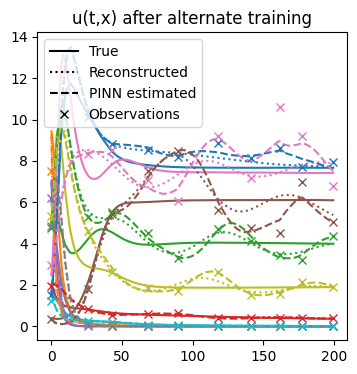

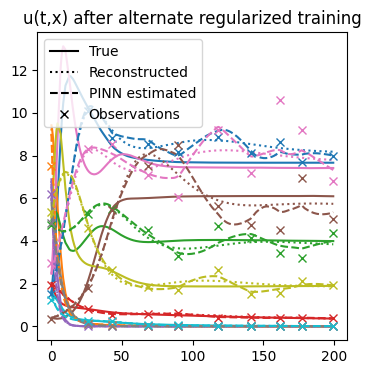

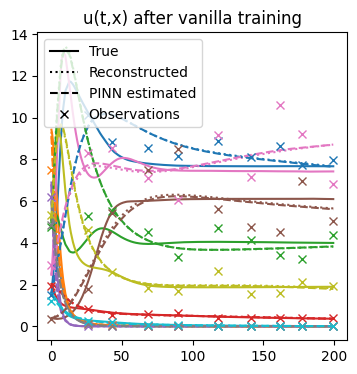

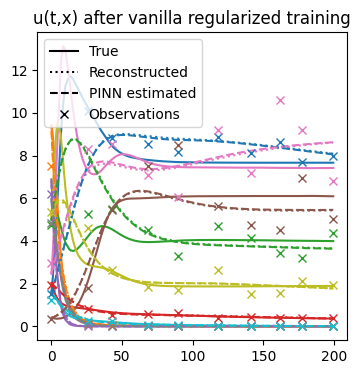

In [89]:
plot_curves(
    "u(t,x) after alternate training", rec_sol_log_alternate, trained_u_est_alternate
)
plot_curves(
    "u(t,x) after alternate regularized training",
    rec_sol_log_alternate_regularized,
    trained_u_est_alternate_regularized,
)
plot_curves("u(t,x) after vanilla training", rec_sol_log_vanilla, trained_u_est_vanilla)
plot_curves(
    "u(t,x) after vanilla regularized training",
    rec_sol_log_vanilla_regularized,
    trained_u_est_vanilla_regularized,
)